In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

remove_attention_failers = 1

In [ ]:
def label_category(tail, shape):
    if tail == "T" and shape == "S":
        return "high"
    elif tail == "N" and shape == "C":
        return "low"
    else:
        return "medium"

def extract_basic_info(csv_path):
    df = pd.read_csv(csv_path)


    # Food reported across training trials
    train_responses = df['slider_train.response'].dropna().tolist()

    #Actual food needed (food needed on each training trial)
    food_amount = df['food_amount'].dropna().tolist()
    
    # Feedback (free text response about experiment)
    feedback = df['feedback_text.text'].dropna().tolist()
    
    # Trial stop time (time it took to finish the training loop)
    isi_values = df['ISI.stopped'].dropna().tolist()

    #Get the ISI value for the last training trial, store it
    trial_stop_time = isi_values[-1] if isi_values else np.nan

    #First row with a non-empty value in 'images_list', which shows the order of testing images presented
    images_row = df[df['images_list'].notna()].iloc[0] if not df[df['images_list'].notna()].empty else None

    #Turn the images from PNGs to names
    images = [img.split('/')[-1].replace('.png','') for img in images_row['images_list'].split(',')]

    #First row with a non-empty value in 'sliderRatings', which shows the ratings for testing images
    ratings_row = df[df['sliderRatings'].notna()].iloc[0] if not df[df['sliderRatings'].notna()].empty else None

    #Turn them into floats split by commas
    ratings = [float(r) for r in ratings_row['sliderRatings'].strip('[]').split(',')]

    #Across the training trials, add information about features (what food category, what feature)
    train_categories =  df['category'].dropna().tolist()
    train_tail = df['tail'].dropna().tolist()
    train_shape = df['shape'].dropna().tolist()
    train_color = df['color'].dropna().tolist()
    
    #Categories for the testing images, in the order shown
    test_categories = [label_category(stim.split('_')[0], stim.split('_')[2]) for stim in images]
    
    #Write condition (this is the unique identifier for a certain order of trials)
    condition = images_row['condition'] if images_row is not None and 'condition' in images_row else np.nan

    #Add in the order of images during training
    training_image_order = [img.split('/')[-1].replace('.png','') 
                        for img in df['image_file'].dropna().tolist()]


    #Updated code to get slider responses (subjective reports of feature relevance)

    slider_responses = {}
    features = ['shape', 'color', 'tail']
    for feat in features:
        # subset only rows of this feature
        sub = df[df['feature'] == feat]

        # 1. discrete
        disc = sub['discrete_slider.response']
        disc_val = disc[disc.notna() & (disc != "")].iloc[0] if (disc.notna() & (disc != "")).any() else np.nan
        slider_responses[f'{feat}_discrete_slider.response'] = disc_val

        # 2. direction (only for "Yes" responses)
        dirc = sub['direction_response_label']
        dirc_val = dirc[dirc.notna() & (dirc != "")].iloc[0] if (dirc.notna() & (dirc != "")).any() and disc_val != 'No' else np.nan
        slider_responses[f'{feat}_direction_slider.response'] = dirc_val

        # 3. continuous
        cont = sub['continuous_slider.response']
        cont_val = cont[cont.notna() & (cont != "")].iloc[0] if (cont.notna() & (cont != "")).any() and disc_val != 'No' else np.nan
        slider_responses[f'{feat}_continuous_slider.response'] = cont_val

    #Adding attention check result
    att_rows = df[df['answer_3_right.numClicks'].notna()]
    if not att_rows.empty:
        att_val = att_rows.iloc[0]['answer_3_right.numClicks']
    else:
        att_val = np.nan

    # Convert to pass/fail (1 = correct, 0 = incorrect)
    attention_check = 1 if att_val == 1 else 0


    result = {
        'participant': os.path.basename(csv_path)[:3], #participant number
        'training_responses': train_responses, #Response during training 
        'food_amount': food_amount, #real food amount displayed that trial
        'error': [abs(pred - actual) for pred, actual in zip(train_responses, food_amount)],
        'feedback': feedback,
        'trial_stop_time': trial_stop_time,
        'testing_image_order': images,
        'testing_responses': ratings,
        'training_categories': train_categories,
        'training_tail': train_tail,
        'training_shape': train_shape,
        'training_color': train_color,
        'testing_categories': test_categories,
        'conditionOrder': condition, #
        'training_image_order': training_image_order,
        'attention_check': attention_check
    }
    result.update(slider_responses)
    return result

topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'Pilot'
datadir = os.path.join(topdir, f'data/{study}/Predict')
cleaneddir = os.path.join(topdir, f'data/{study}/Cleaned')
all_participants = []

for fname in os.listdir(datadir):
    if fname.endswith('.csv') and fname:
        participant_id = fname[:3]
        if '2025-11-28' not in fname:  # skip files
            continue
        csv_path = os.path.join(datadir, fname)
        print(csv_path)
        info = extract_basic_info(csv_path)
        all_participants.append(info)


df_all = pd.DataFrame(all_participants)
if remove_attention_failers:
    df_all = df_all[df_all['attention_check'] == 1]
    df_all.to_csv(os.path.join(cleaneddir, f'{study}Predict.csv'), index=False)
else:
    df_all.to_csv(os.path.join(cleaneddir, f'{study}Predict.csv'), index=False)

print(df_all[df_all['attention_check'] == 1])

/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Pilot/Predict/006_test_2025-11-28_11h07.42.870.csv
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Pilot/Predict/009_test_2025-11-28_11h07.55.847.csv
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Pilot/Predict/015_test_2025-11-28_11h09.13.888.csv
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Pilot/Predict/022_test_2025-11-28_11h19.40.085.csv
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Pilot/Predict/012_test_2025-11-28_10h07.28.827.csv
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Pilot/Predict/010_test_2025-11-28_10h07.20.226.csv
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Pilot/Predict/007_test_2025-11-28_11h05.27.781.csv
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Pilot/Predict/003_test_2025-11-28_10h02.30.219.csv
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Pilot/Predict/008_test_2025-11-28_10h07.06.384.csv
/Users/sm6511/Desktop/Prediction-Accomodation-

In [25]:
print(df_all['attention_check'].sum())

21


In [3]:
participant_id = '003'

row = df_all[df_all['participant'] == participant_id]

responses = row['train_responses'].iloc[0] 
ratings = row['ratings'].iloc[0] 
feedback = row['feedback'].iloc[0]
print(f"Train responses {participant_id}:")
for i, text in enumerate(responses, 1):
    print(f"Response {i}: {text}")

print(f"\nFeedback for participant {participant_id}: {feedback}")
print(f"\nFeedback for participant {participant_id}: {ratings}")

Train responses 003:
Response 1: 4.0
Response 2: 9.0
Response 3: 7.0
Response 4: 9.0
Response 5: 5.0
Response 6: 7.0
Response 7: 7.0
Response 8: 4.0
Response 9: 4.0
Response 10: 5.0
Response 11: 3.0
Response 12: 5.0
Response 13: 5.0
Response 14: 5.0
Response 15: 6.0
Response 16: 8.0
Response 17: 5.0
Response 18: 5.0
Response 19: 7.0
Response 20: 3.0
Response 21: 6.0
Response 22: 9.0
Response 23: 5.0
Response 24: 9.0

Feedback for participant 003: []

Feedback for participant 003: [7.0, 3.0, 5.0, 6.0, 9.0, 9.0, 7.0, 4.0]


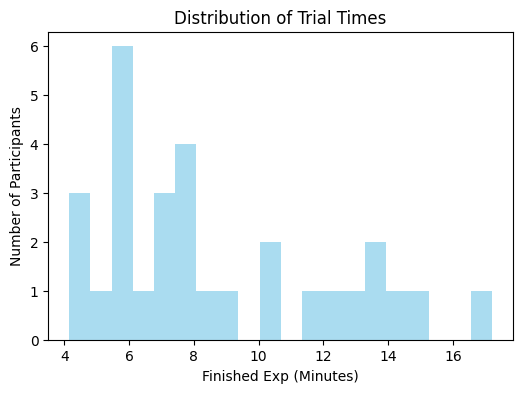

In [4]:
plt.figure(figsize=(6,4))
plt.hist(df_all['trial_stop_time'].dropna()/60, bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Finished Exp (Minutes)')
plt.ylabel('Number of Participants')
plt.title('Distribution of Trial Times')
plt.savefig('PrePilotPlots/trial_times_histogramPredict.png')
plt.show()

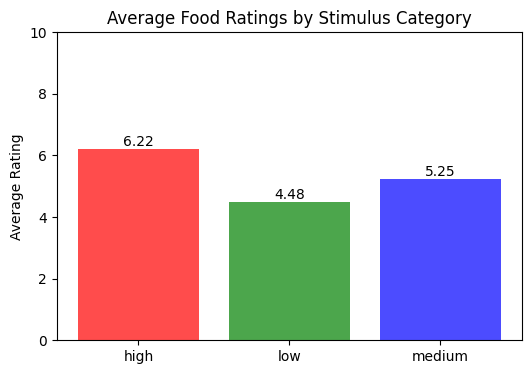

In [5]:
def AverageFoodCalclator(participants_to_use):
    df_subset = df_all[df_all['participant'].isin(participants_to_use)]
    all_trials = []
    for i in df_subset['participant']:
        trial_order = df_subset[df_subset['participant'] == i]['image_order'].iloc[0]
        ratings = df_subset[df_subset['participant'] == i]['ratings'].iloc[0]
        categories = df_subset[df_subset['participant'] == i]['categories'].iloc[0]
    
        df_participant = pd.DataFrame({
            'participant': i,
            'trial_order': trial_order,
            'ratings': ratings,
            'categories': categories
        })
        all_trials.append(df_participant)
    df_average = pd.concat(all_trials, ignore_index=True)
    avg_ratings = df_average.groupby('categories')['ratings'].mean()
    return avg_ratings

participants_to_use = df_all['participant'].tolist()
#participants_to_use = ['002', '003', '004']
avg_ratings = AverageFoodCalclator(participants_to_use)

plt.figure(figsize=(6,4))
bars = plt.bar(avg_ratings.index, avg_ratings.values, color=['red','green','blue'], alpha=0.7)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f"{bar.get_height():.2f}", ha='center')
plt.ylabel('Average Rating')
plt.title('Average Food Ratings by Stimulus Category')
plt.ylim(0, 10)
plt.savefig('PrePilotPlots/FoodRatingsPredict.png')
plt.show()


In [6]:
'shape_discrete_slider.response',
'color_discrete_slider.response',
'tail_discrete_slider.response',
'shape_direction_slider.response',
'color_direction_slider.response',
'tail_direction_slider.response',
'shape_continuous_slider.response',
'color_continuous_slider.response',
'tail_continuous_slider.response'

shape_relevance = 0
tail_relevance = 0
color_relevance = 0
for i in df_all['participant']:
    tail_int = df_all[df_all['participant'] == i]['tail_discrete_slider.response'].iloc[0]
    shape_int = df_all[df_all['participant'] == i]['shape_discrete_slider.response'].iloc[0]
    color_int = df_all[df_all['participant'] == i]['color_discrete_slider.response'].iloc[0]
    tail_relevance += 1 if tail_int == 'Yes' else 0
    shape_relevance += 1 if shape_int == 'Yes' else 0
    color_relevance += 1 if color_int== 'Yes' else 0
print("Tail Relevance:",  tail_relevance)
print("Shape Relevance", shape_relevance)
print("Color Relevance", color_relevance)





Tail Relevance: 19
Shape Relevance 21
Color Relevance 20


In [14]:
columns_direction = [
    'shape_direction_slider.response',
    'color_direction_slider.response',
    'tail_direction_slider.response',]
columns_continuous = [
    'shape_continuous_slider.response',
    'color_continuous_slider.response',
    'tail_continuous_slider.response']

for col in columns_direction:
    print(df_all[col].value_counts(dropna=False))
for col in columns_continuous:
    print(f"Average of {col}: {df_all[col].mean()}, n = {df_all[col].count()}")


shape_direction_slider.response
Square      17
NaN         10
Circular     3
Name: count, dtype: int64
color_direction_slider.response
NaN       14
Blue      12
Yellow     4
Name: count, dtype: int64
tail_direction_slider.response
NaN               15
Having a tail     11
Having no tail     4
Name: count, dtype: int64
Average of shape_continuous_slider.response: 4.65, n = 20
Average of color_continuous_slider.response: 4.631578947368421, n = 19
Average of tail_continuous_slider.response: 4.2105263157894735, n = 19
